## Prepare the workspace

In [1]:
# Before you proceed, update the PATH
import os
# os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"
# os.environ['PATH'] = f"{os.environ['PATH']}:/opt/conda/lib/python3.6/site-packages"
# Restart the Kernel at this point. 

In [1]:
# Do not execute the commands below unless you have restart the Kernel after updating the PATH. 
# !python -m pip install torch==1.0.0

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement torch==1.0.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1)
ERROR: No matching distribution found for torch==1.0.0


In [1]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled. 

2.0.1
True


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [86]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import os, random
import json
import signal
from torch.autograd import Variable
from PIL import Image
from torchvision import transforms, datasets , models
from torchvision.datasets import ImageFolder
from torch.utils import data
from matplotlib.ticker import FormatStrFormatter
from collections import OrderedDict 
from contextlib import contextmanager
from tqdm import tqdm
from torch.optim import lr_scheduler
import copy
import time
from collections  import OrderedDict
import peft
import timm
import torchvision.models.quantization as qmodels
import torchinfo
import json
import os
import shutil
from prettytable import PrettyTable
from torch.quantization import convert
%config IPCompleter.greedy=True
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). 

If you do not find the `flowers/` dataset in the current directory, **/workspace/home/aipnd-project/**, you can download it using the following commands. 

```bash
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers
```


## Data Description
The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    'training' : transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                        [0.229, 0.224, 0.225])]),
                                                            
    'validation' : transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])]),

    'testing' : transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
}

# TODO: Load the datasets with ImageFolder
image_datasets = {
    'training' : datasets.ImageFolder(train_dir, transform=data_transforms['training']),
    'testing' : datasets.ImageFolder(test_dir, transform=data_transforms['testing']),
    'validation' : datasets.ImageFolder(valid_dir, transform=data_transforms['validation'])
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders =  {
    'training' : torch.utils.data.DataLoader(image_datasets['training'], batch_size=64, shuffle=True),
    'testing' : torch.utils.data.DataLoader(image_datasets['testing'], batch_size=64, shuffle=False),
    'validation' : torch.utils.data.DataLoader(image_datasets['validation'], batch_size=64, shuffle=True)
}



### Sample Image:

224


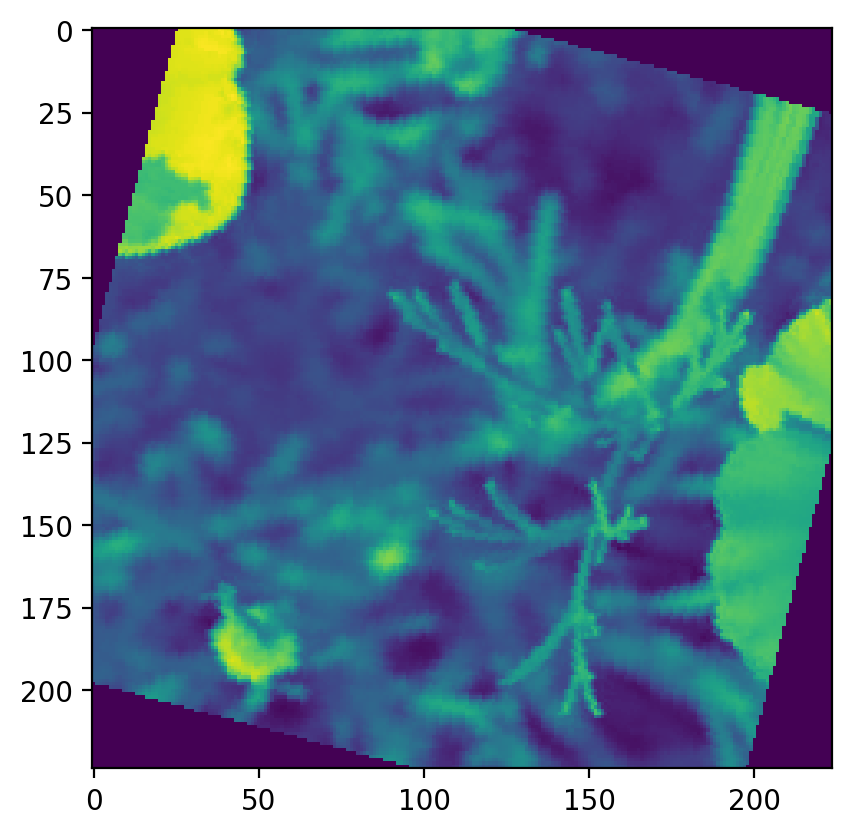

In [5]:
images, labels = next(iter(dataloaders["training"]))
print(len(images[0,2]))
plt.imshow(images[34,1])

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:


with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

## Note for Workspace users: 
If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

## Transfer Learning on EfficientNet_V2_S:

In [329]:
def get_model(device='cuda'):
    """
    Retrieves a pre-trained EfficientNet model and prints its summary.

    Args:
        device (str): Device to run the model on. Default is 'cuda'.

    Returns:
        model: Pre-trained EfficientNet model.
    """
    # Create a pre-trained efficientnet_v2_s model
    model = timm.create_model('tf_efficientnetv2_s', pretrained=True)
    model.to(device)
    return model

def build_model(hidden_units, class_to_idx, device):
    """
    Builds a new model with a pre-trained EfficientNet backbone.

    Returns:
        model: New model with a pre-trained EfficientNet backbone.
    """
    model = get_model(device=device)
    for param in model.parameters():
        param.requires_grad = False
    classifier_input_size = model.classifier.in_features
    print(" classifier_input_size: ", classifier_input_size)
    output_size = 102
    # Define the new classifier
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(classifier_input_size, (hidden_units//2))),
        ('bn1', nn.BatchNorm1d(hidden_units//2)),
        ('relu', nn.ReLU()),
        ('dropout1', nn.Dropout(p=0.05)),
        ('fc2', nn.Linear((hidden_units//2), (hidden_units))),
        ('bn2',nn.BatchNorm1d(hidden_units)),
        ('relu', nn.ReLU()),
        ('dropout2', nn.Dropout(p=0.05)),
        ('fc3', nn.Linear((hidden_units), output_size)),
        ('output', nn.LogSoftmax(dim=1))
    ]))

    model.classifier = classifier
    model.class_to_idx = class_to_idx
    model = model.to(device)  # Move model to device
    return classifier_input_size,model

In [330]:
# Use GPU if available
if torch.cuda.is_available():
    device = 'cuda'
class_to_idx = image_datasets['training'].class_to_idx
hidden_layers = 512
in_sz,model = build_model(hidden_units=hidden_layers, class_to_idx=class_to_idx , device=device)

 classifier_input_size:  1280


In [279]:
[(n, type(m)) for n, m in model.named_modules()][:50]

[('', timm.models.efficientnet.EfficientNet),
 ('conv_stem', timm.layers.conv2d_same.Conv2dSame),
 ('bn1', timm.layers.norm_act.BatchNormAct2d),
 ('bn1.drop', torch.nn.modules.linear.Identity),
 ('bn1.act', torch.nn.modules.activation.SiLU),
 ('blocks', torch.nn.modules.container.Sequential),
 ('blocks.0', torch.nn.modules.container.Sequential),
 ('blocks.0.0', timm.models._efficientnet_blocks.ConvBnAct),
 ('blocks.0.0.conv', torch.nn.modules.conv.Conv2d),
 ('blocks.0.0.bn1', timm.layers.norm_act.BatchNormAct2d),
 ('blocks.0.0.bn1.drop', torch.nn.modules.linear.Identity),
 ('blocks.0.0.bn1.act', torch.nn.modules.activation.SiLU),
 ('blocks.0.0.drop_path', torch.nn.modules.linear.Identity),
 ('blocks.0.1', timm.models._efficientnet_blocks.ConvBnAct),
 ('blocks.0.1.conv', torch.nn.modules.conv.Conv2d),
 ('blocks.0.1.bn1', timm.layers.norm_act.BatchNormAct2d),
 ('blocks.0.1.bn1.drop', torch.nn.modules.linear.Identity),
 ('blocks.0.1.bn1.act', torch.nn.modules.activation.SiLU),
 ('blocks.0

In [280]:
linear_modules = [n for n, m in model.named_modules() if type(m).__name__ == 'Linear']
print(linear_modules)

['classifier.fc1', 'classifier.fc2', 'classifier.fc3']


In [281]:
config = peft.LoraConfig(r=8, target_modules=linear_modules, modules_to_save=["head.fc"])


### Vanilla EfficientNet_V2_SModel Summary

In [282]:

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
count_parameters(model)

+-----------------------+------------+
|        Modules        | Parameters |
+-----------------------+------------+
| classifier.fc1.weight |   327680   |
|  classifier.fc1.bias  |    256     |
| classifier.bn1.weight |    256     |
|  classifier.bn1.bias  |    256     |
| classifier.fc2.weight |   131072   |
|  classifier.fc2.bias  |    512     |
| classifier.bn2.weight |    512     |
|  classifier.bn2.bias  |    512     |
| classifier.fc3.weight |   52224    |
|  classifier.fc3.bias  |    102     |
+-----------------------+------------+
Total Trainable Params: 513382


513382

In [ ]:

torchinfo.summary(model, input_size=(1, 3, 224, 224), col_names=("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose=0)

In [283]:


def train(model, epochs, learning_rate, scheduler, criterion,optimizer, training_loader, validation_loader, device):

    # Use GPU if available
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
    train_losses = []
    valid_losses= []
    train_accuracies=[]
    valid_accuracies=[]
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_val_loss = float('inf')
    epochs_no_improve = 0
    n_epochs_stop = 7  # Number of epochs to wait before stopping
    # Initialize a figure
    fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))
    plt.ion()  # Turn interactive mode on
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = training_loader
            else:
                model.eval()   # Set model to evaluate mode
                data_loader = validation_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0  # Initialize total samples count

            # Iterate over data with progress bar.
            with tqdm(data_loader, unit="batch") as t:
                for inputs, labels in t:                
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            scheduler.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)  # Update total samples count

                    # Update progress bar description
                    t.set_description(f'Running {phase} Loss: {running_loss / total_samples:.4f} Running Accuracy: {running_corrects.double() / total_samples:.4f}')

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            print('Final {} Loss: {:.4f} Final Accuracy: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # Append metrics to lists
            if phase == 'train':
                train_losses.append(epoch_loss.item() if torch.is_tensor(epoch_loss) else epoch_loss)
                train_accuracies.append(epoch_acc.item() if torch.is_tensor(epoch_acc) else epoch_acc)
            else:
                valid_losses.append(epoch_loss.item() if torch.is_tensor(epoch_loss) else epoch_loss)
                valid_accuracies.append(epoch_acc.item() if torch.is_tensor(epoch_acc) else epoch_acc)
                        
            # Update plots
            ax1.plot(np.array(train_losses), 'r', label='Training loss')  # Red for training loss
            ax1.plot(np.array(valid_losses), 'orange', label='Validation loss')  # Orange for validation loss
            ax1.set_title('Loss per epoch')
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel('Loss')
            ax1.legend()

            ax2.plot(np.array(train_accuracies), 'b', label='Training accuracy')  # Blue for training accuracy
            ax2.plot(np.array(valid_accuracies), 'g', label='Validation accuracy')  # Green for validation accuracy
            ax2.set_title('Accuracy per epoch')
            ax2.set_xlabel('Epochs')
            ax2.set_ylabel('Accuracy')
            ax2.legend()

            fig.canvas.draw()
            plt.pause(0.001)
            # At the end of each epoch, check validation loss
            if phase == 'valid':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if epoch_loss < best_val_loss:
                    # If the validation loss is lower than our current best, update the best loss and reset the count
                    best_val_loss = epoch_loss
                    epochs_no_improve = 0
                else:
                    # If the validation loss didn't improve, increment the count
                    epochs_no_improve += 1
                    if epochs_no_improve == n_epochs_stop:
                        print('Early stopping!')
                        # Load the best state dict
                        model.load_state_dict(best_model_wts)
                        # Exit the loop
                        break

        # If the model was early stopped, exit the outer loop as well
        if epochs_no_improve == n_epochs_stop:
            break

    print('Best validation Accuracy: {:4f}'.format(best_acc))
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

### ***Model Summary before LoRA***

In [284]:

torchinfo.summary(model, input_size=(1, 3, 224, 224), col_names=("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose=0)
# Get the summary
#torchinfo.summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
EfficientNet                                  [1, 3, 224, 224]          [1, 102]                  --                        --                        --
├─Conv2dSame: 1-1                             [1, 3, 224, 224]          [1, 24, 112, 112]         (648)                     [3, 3]                    8,128,512
├─BatchNormAct2d: 1-2                         [1, 24, 112, 112]         [1, 24, 112, 112]         48                        --                        --
│    └─Identity: 2-1                          [1, 24, 112, 112]         [1, 24, 112, 112]         --                        --                        --
│    └─SiLU: 2-2                              [1, 24, 112, 112]         [1, 24, 112, 112]         --                        --                        --
├─Sequential: 1-3                             [1, 24, 112, 112]     

### **Implementing LoRA on EfficientNet**

In [285]:
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 50
learning_rate = 0.01
peft_model = peft.get_peft_model(model, config).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(peft_model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max = 32, eta_min = 1e-4)
peft_model.print_trainable_parameters()

trainable params: 23,344 || all params: 20,714,214 || trainable%: 0.11269556257360284


### ***Model Summary after LoRA***

In [286]:

torchinfo.summary(peft_model, input_size=(1, 3, 224, 224), col_names=("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose=0)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
PeftModel                                               [1, 3, 224, 224]          [1, 102]                  --                        --                        --
├─LoraModel: 1-1                                        --                        --                        --                        --                        --
│    └─EfficientNet: 2-1                                [1, 3, 224, 224]          [1, 102]                  --                        --                        --
│    │    └─Conv2dSame: 3-1                             [1, 3, 224, 224]          [1, 24, 112, 112]         (648)                     [3, 3]                    8,128,512
│    │    └─BatchNormAct2d: 3-2                         [1, 24, 112, 112]         [1, 24, 112, 112]         (48)                      --                        0
│    │   

### Training LoRA EfficientNet model

Epoch 1/50
----------


Running train Loss: 4.3917 Running Accuracy: 0.0723: 100%|██████████| 103/103 [01:02<00:00,  1.64batch/s]


Final train Loss: 4.3917 Final Accuracy: 0.0723


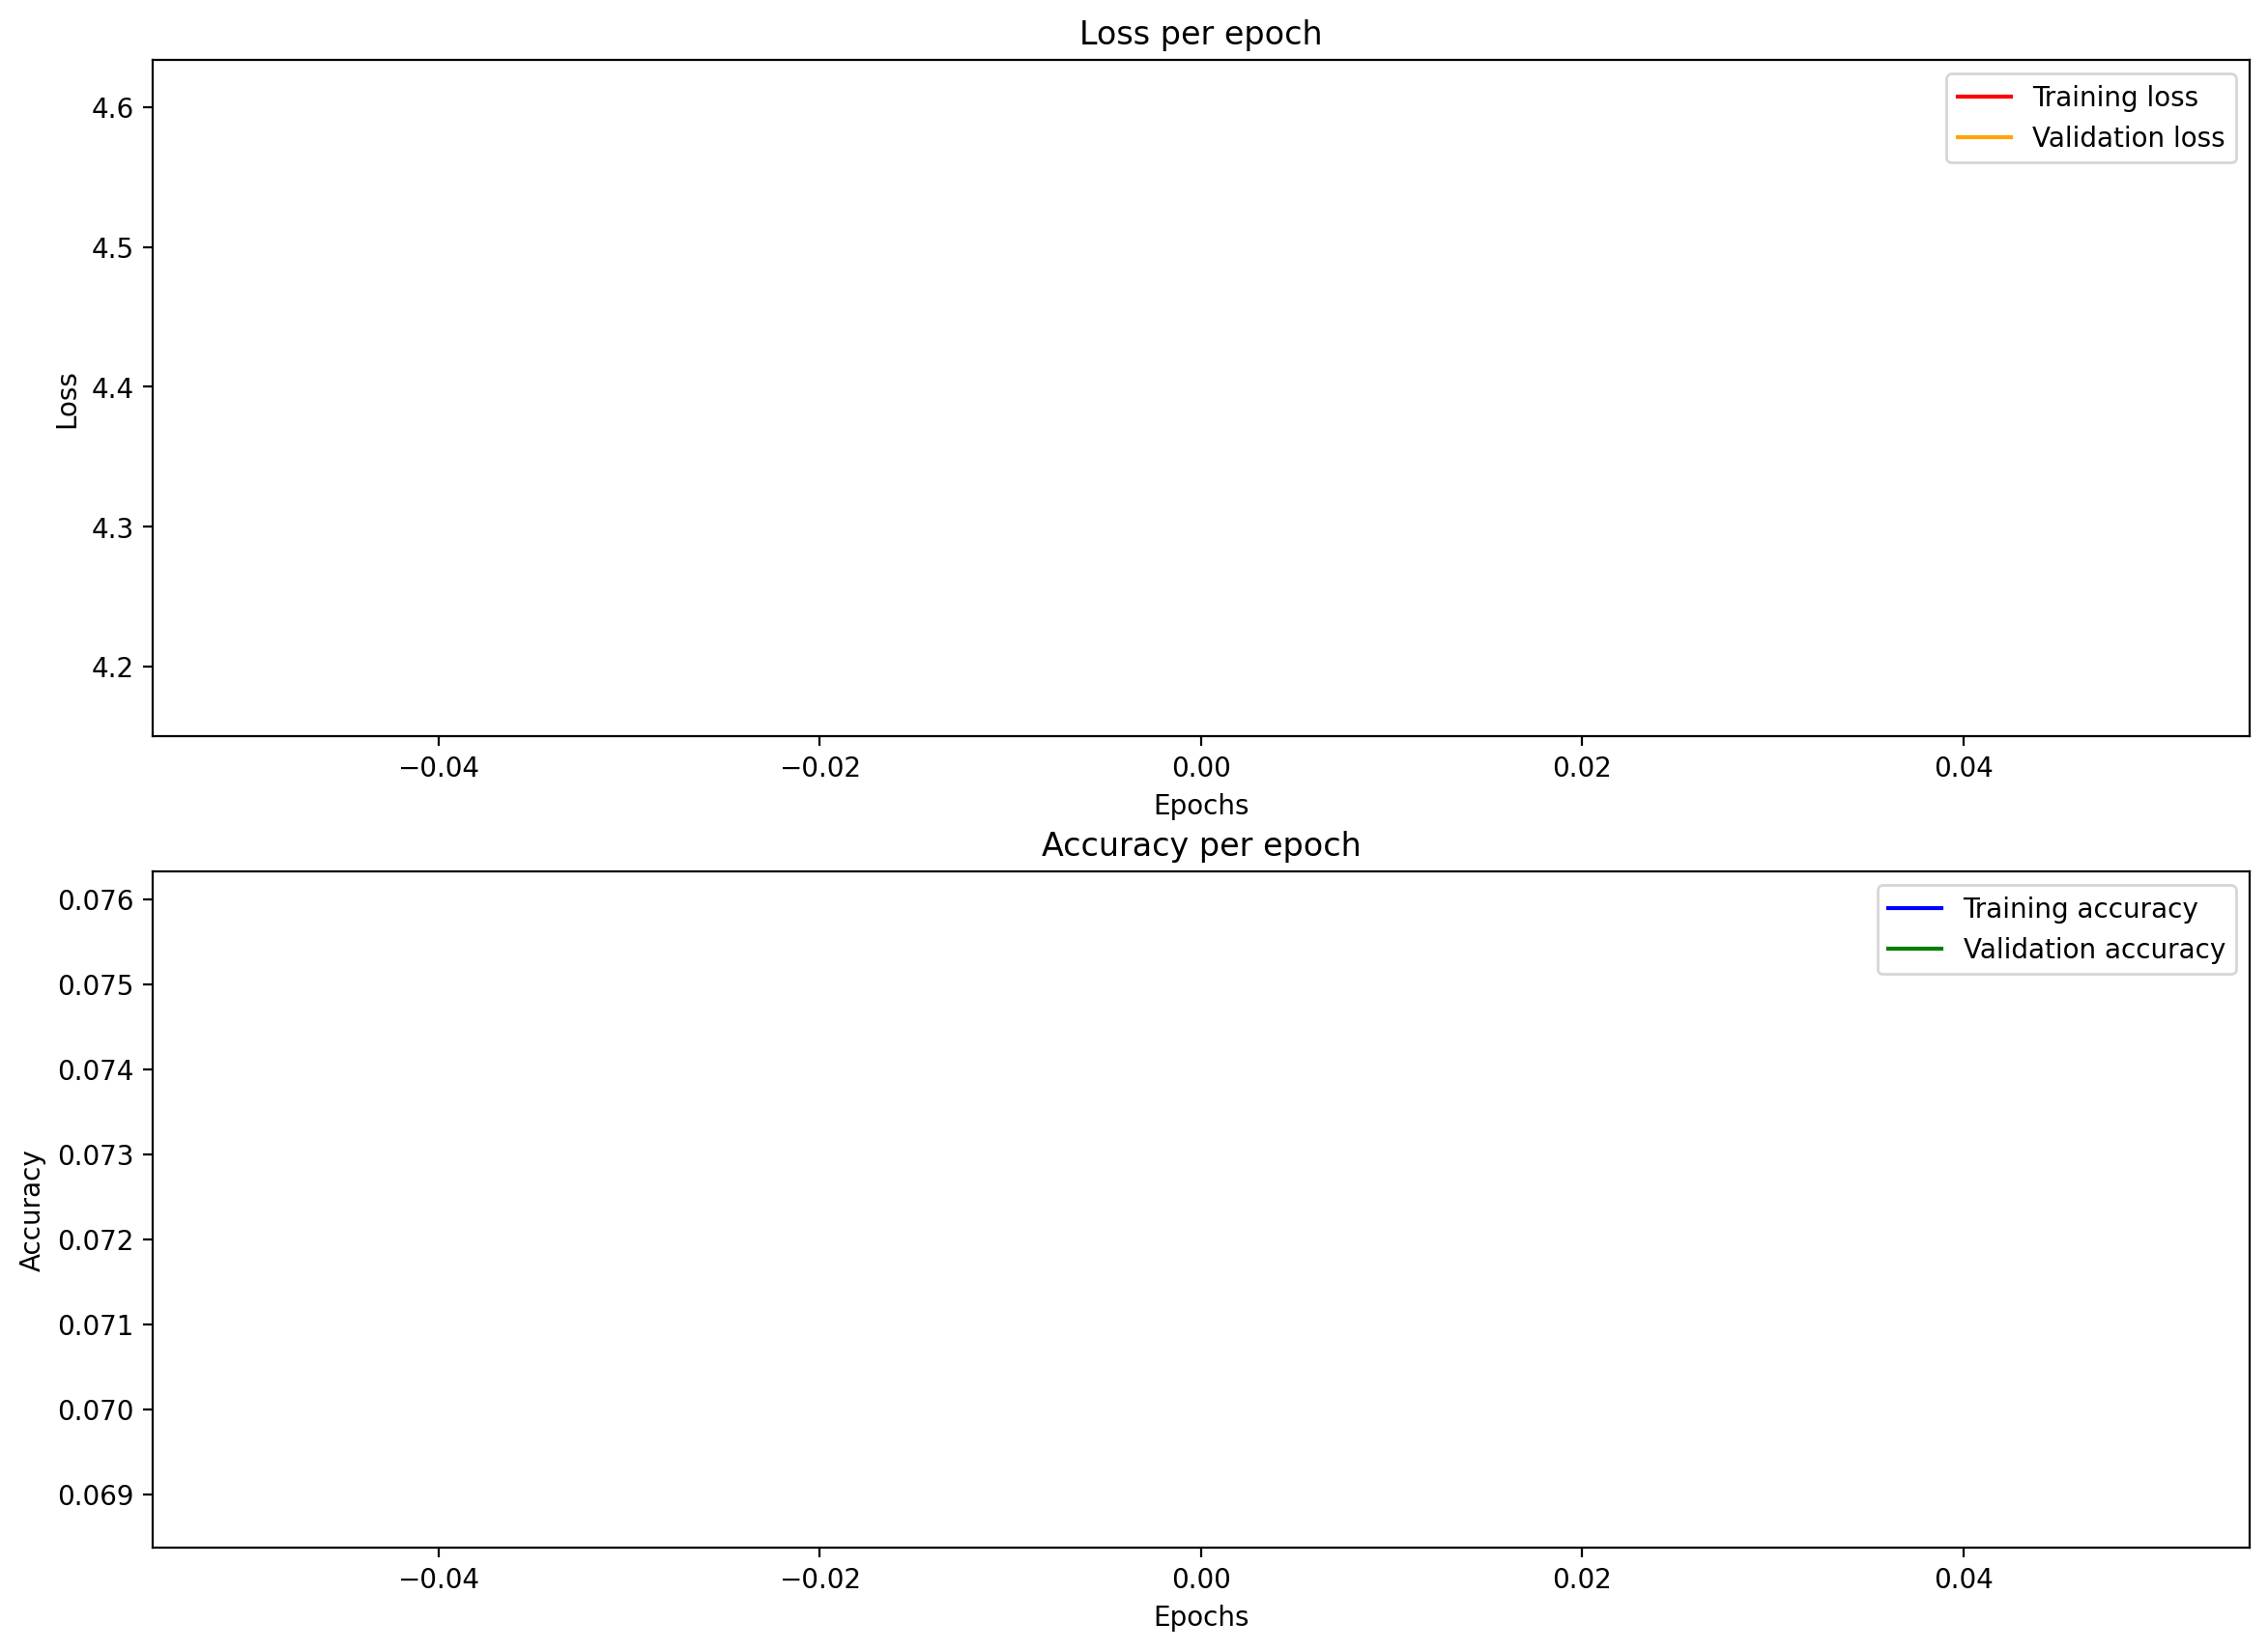

Running valid Loss: 3.7824 Running Accuracy: 0.1516: 100%|██████████| 13/13 [00:07<00:00,  1.64batch/s]


Final valid Loss: 3.7824 Final Accuracy: 0.1516
Epoch 2/50
----------


Running train Loss: 3.1780 Running Accuracy: 0.2476: 100%|██████████| 103/103 [01:07<00:00,  1.53batch/s]


Final train Loss: 3.1780 Final Accuracy: 0.2476


Running valid Loss: 2.6887 Running Accuracy: 0.3594: 100%|██████████| 13/13 [00:08<00:00,  1.54batch/s]


Final valid Loss: 2.6887 Final Accuracy: 0.3594
Epoch 3/50
----------


Running train Loss: 2.5524 Running Accuracy: 0.3636: 100%|██████████| 103/103 [01:01<00:00,  1.67batch/s]


Final train Loss: 2.5524 Final Accuracy: 0.3636


Running valid Loss: 2.2555 Running Accuracy: 0.4499: 100%|██████████| 13/13 [00:07<00:00,  1.65batch/s]


Final valid Loss: 2.2555 Final Accuracy: 0.4499
Epoch 4/50
----------


Running train Loss: 2.1915 Running Accuracy: 0.4394: 100%|██████████| 103/103 [00:59<00:00,  1.73batch/s]


Final train Loss: 2.1915 Final Accuracy: 0.4394


Running valid Loss: 1.8954 Running Accuracy: 0.5269: 100%|██████████| 13/13 [00:07<00:00,  1.68batch/s]


Final valid Loss: 1.8954 Final Accuracy: 0.5269
Epoch 5/50
----------


Running train Loss: 1.9725 Running Accuracy: 0.4847: 100%|██████████| 103/103 [00:58<00:00,  1.75batch/s]


Final train Loss: 1.9725 Final Accuracy: 0.4847


Running valid Loss: 1.6824 Running Accuracy: 0.6015: 100%|██████████| 13/13 [00:07<00:00,  1.67batch/s]


Final valid Loss: 1.6824 Final Accuracy: 0.6015
Epoch 6/50
----------


Running train Loss: 1.7977 Running Accuracy: 0.5346: 100%|██████████| 103/103 [00:58<00:00,  1.76batch/s]


Final train Loss: 1.7977 Final Accuracy: 0.5346


Running valid Loss: 1.4915 Running Accuracy: 0.6406: 100%|██████████| 13/13 [00:07<00:00,  1.74batch/s]


Final valid Loss: 1.4915 Final Accuracy: 0.6406
Epoch 7/50
----------


Running train Loss: 1.6786 Running Accuracy: 0.5653: 100%|██████████| 103/103 [00:57<00:00,  1.78batch/s]


Final train Loss: 1.6786 Final Accuracy: 0.5653


Running valid Loss: 1.4078 Running Accuracy: 0.6467: 100%|██████████| 13/13 [00:07<00:00,  1.75batch/s]


Final valid Loss: 1.4078 Final Accuracy: 0.6467
Epoch 8/50
----------


Running train Loss: 1.5913 Running Accuracy: 0.5846: 100%|██████████| 103/103 [01:01<00:00,  1.67batch/s]


Final train Loss: 1.5913 Final Accuracy: 0.5846


Running valid Loss: 1.2514 Running Accuracy: 0.7017: 100%|██████████| 13/13 [00:08<00:00,  1.62batch/s]


Final valid Loss: 1.2514 Final Accuracy: 0.7017
Epoch 9/50
----------


Running train Loss: 1.5090 Running Accuracy: 0.6052: 100%|██████████| 103/103 [01:03<00:00,  1.62batch/s]


Final train Loss: 1.5090 Final Accuracy: 0.6052


Running valid Loss: 1.1939 Running Accuracy: 0.7066: 100%|██████████| 13/13 [00:07<00:00,  1.66batch/s]


Final valid Loss: 1.1939 Final Accuracy: 0.7066
Epoch 10/50
----------


Running train Loss: 1.4770 Running Accuracy: 0.6165: 100%|██████████| 103/103 [01:00<00:00,  1.70batch/s]


Final train Loss: 1.4770 Final Accuracy: 0.6165


Running valid Loss: 1.1155 Running Accuracy: 0.7384: 100%|██████████| 13/13 [00:07<00:00,  1.68batch/s]


Final valid Loss: 1.1155 Final Accuracy: 0.7384
Epoch 11/50
----------


Running train Loss: 1.4049 Running Accuracy: 0.6253: 100%|██████████| 103/103 [01:00<00:00,  1.70batch/s]


Final train Loss: 1.4049 Final Accuracy: 0.6253


Running valid Loss: 1.0847 Running Accuracy: 0.7408: 100%|██████████| 13/13 [00:07<00:00,  1.65batch/s]


Final valid Loss: 1.0847 Final Accuracy: 0.7408
Epoch 12/50
----------


Running train Loss: 1.3653 Running Accuracy: 0.6400: 100%|██████████| 103/103 [01:00<00:00,  1.69batch/s]


Final train Loss: 1.3653 Final Accuracy: 0.6400


Running valid Loss: 1.0469 Running Accuracy: 0.7347: 100%|██████████| 13/13 [00:07<00:00,  1.67batch/s]


Final valid Loss: 1.0469 Final Accuracy: 0.7347
Epoch 13/50
----------


Running train Loss: 1.3110 Running Accuracy: 0.6520: 100%|██████████| 103/103 [01:00<00:00,  1.70batch/s]


Final train Loss: 1.3110 Final Accuracy: 0.6520


Running valid Loss: 1.0165 Running Accuracy: 0.7518: 100%|██████████| 13/13 [00:07<00:00,  1.68batch/s]


Final valid Loss: 1.0165 Final Accuracy: 0.7518
Epoch 14/50
----------


Running train Loss: 1.2888 Running Accuracy: 0.6555: 100%|██████████| 103/103 [01:00<00:00,  1.69batch/s]


Final train Loss: 1.2888 Final Accuracy: 0.6555


Running valid Loss: 0.9524 Running Accuracy: 0.7592: 100%|██████████| 13/13 [00:07<00:00,  1.69batch/s]


Final valid Loss: 0.9524 Final Accuracy: 0.7592
Epoch 15/50
----------


Running train Loss: 1.2872 Running Accuracy: 0.6557: 100%|██████████| 103/103 [00:59<00:00,  1.75batch/s]


Final train Loss: 1.2872 Final Accuracy: 0.6557


Running valid Loss: 0.9739 Running Accuracy: 0.7506: 100%|██████████| 13/13 [00:08<00:00,  1.61batch/s]


Final valid Loss: 0.9739 Final Accuracy: 0.7506
Epoch 16/50
----------


Running train Loss: 1.2287 Running Accuracy: 0.6722: 100%|██████████| 103/103 [00:59<00:00,  1.74batch/s]


Final train Loss: 1.2287 Final Accuracy: 0.6722


Running valid Loss: 0.9592 Running Accuracy: 0.7653: 100%|██████████| 13/13 [00:07<00:00,  1.70batch/s]


Final valid Loss: 0.9592 Final Accuracy: 0.7653
Epoch 17/50
----------


Running train Loss: 1.2200 Running Accuracy: 0.6735: 100%|██████████| 103/103 [00:59<00:00,  1.74batch/s]


Final train Loss: 1.2200 Final Accuracy: 0.6735


Running valid Loss: 0.9086 Running Accuracy: 0.7653: 100%|██████████| 13/13 [00:07<00:00,  1.71batch/s]


Final valid Loss: 0.9086 Final Accuracy: 0.7653
Epoch 18/50
----------


Running train Loss: 1.2137 Running Accuracy: 0.6758: 100%|██████████| 103/103 [00:59<00:00,  1.74batch/s]


Final train Loss: 1.2137 Final Accuracy: 0.6758


Running valid Loss: 0.9128 Running Accuracy: 0.7543: 100%|██████████| 13/13 [00:07<00:00,  1.69batch/s]


Final valid Loss: 0.9128 Final Accuracy: 0.7543
Epoch 19/50
----------


Running train Loss: 1.1975 Running Accuracy: 0.6859: 100%|██████████| 103/103 [00:59<00:00,  1.74batch/s]


Final train Loss: 1.1975 Final Accuracy: 0.6859


Running valid Loss: 0.8781 Running Accuracy: 0.7689: 100%|██████████| 13/13 [00:07<00:00,  1.68batch/s]


Final valid Loss: 0.8781 Final Accuracy: 0.7689
Epoch 20/50
----------


Running train Loss: 1.1833 Running Accuracy: 0.6853: 100%|██████████| 103/103 [00:58<00:00,  1.75batch/s]


Final train Loss: 1.1833 Final Accuracy: 0.6853


Running valid Loss: 0.8441 Running Accuracy: 0.7824: 100%|██████████| 13/13 [00:07<00:00,  1.71batch/s]


Final valid Loss: 0.8441 Final Accuracy: 0.7824
Epoch 21/50
----------


Running train Loss: 1.1728 Running Accuracy: 0.6957: 100%|██████████| 103/103 [00:59<00:00,  1.74batch/s]


Final train Loss: 1.1728 Final Accuracy: 0.6957


Running valid Loss: 0.8121 Running Accuracy: 0.7836: 100%|██████████| 13/13 [00:07<00:00,  1.70batch/s]


Final valid Loss: 0.8121 Final Accuracy: 0.7836
Epoch 22/50
----------


Running train Loss: 1.1764 Running Accuracy: 0.6935: 100%|██████████| 103/103 [00:59<00:00,  1.73batch/s]


Final train Loss: 1.1764 Final Accuracy: 0.6935


Running valid Loss: 0.8300 Running Accuracy: 0.7751: 100%|██████████| 13/13 [00:07<00:00,  1.72batch/s]


Final valid Loss: 0.8300 Final Accuracy: 0.7751
Epoch 23/50
----------


Running train Loss: 1.1463 Running Accuracy: 0.6957: 100%|██████████| 103/103 [00:58<00:00,  1.77batch/s]


Final train Loss: 1.1463 Final Accuracy: 0.6957


Running valid Loss: 0.8205 Running Accuracy: 0.7946: 100%|██████████| 13/13 [00:07<00:00,  1.75batch/s]


Final valid Loss: 0.8205 Final Accuracy: 0.7946
Epoch 24/50
----------


Running train Loss: 1.1501 Running Accuracy: 0.6995: 100%|██████████| 103/103 [00:58<00:00,  1.77batch/s]


Final train Loss: 1.1501 Final Accuracy: 0.6995


Running valid Loss: 0.7903 Running Accuracy: 0.7995: 100%|██████████| 13/13 [00:07<00:00,  1.75batch/s]


Final valid Loss: 0.7903 Final Accuracy: 0.7995
Epoch 25/50
----------


Running train Loss: 1.1329 Running Accuracy: 0.6984: 100%|██████████| 103/103 [00:58<00:00,  1.76batch/s]


Final train Loss: 1.1329 Final Accuracy: 0.6984


Running valid Loss: 0.8242 Running Accuracy: 0.7677: 100%|██████████| 13/13 [00:07<00:00,  1.72batch/s]


Final valid Loss: 0.8242 Final Accuracy: 0.7677
Epoch 26/50
----------


Running train Loss: 1.1123 Running Accuracy: 0.7071: 100%|██████████| 103/103 [00:58<00:00,  1.77batch/s]


Final train Loss: 1.1123 Final Accuracy: 0.7071


Running valid Loss: 0.7932 Running Accuracy: 0.7922: 100%|██████████| 13/13 [00:07<00:00,  1.69batch/s]


Final valid Loss: 0.7932 Final Accuracy: 0.7922
Epoch 27/50
----------


Running train Loss: 1.1232 Running Accuracy: 0.6987: 100%|██████████| 103/103 [00:58<00:00,  1.76batch/s]


Final train Loss: 1.1232 Final Accuracy: 0.6987


Running valid Loss: 0.8044 Running Accuracy: 0.7873: 100%|██████████| 13/13 [00:07<00:00,  1.72batch/s]


Final valid Loss: 0.8044 Final Accuracy: 0.7873
Epoch 28/50
----------


Running train Loss: 1.0735 Running Accuracy: 0.7123: 100%|██████████| 103/103 [01:08<00:00,  1.50batch/s]


Final train Loss: 1.0735 Final Accuracy: 0.7123


Running valid Loss: 0.7680 Running Accuracy: 0.8056: 100%|██████████| 13/13 [00:09<00:00,  1.31batch/s]


Final valid Loss: 0.7680 Final Accuracy: 0.8056
Epoch 29/50
----------


Running train Loss: 1.1343 Running Accuracy: 0.6960: 100%|██████████| 103/103 [01:03<00:00,  1.63batch/s]


Final train Loss: 1.1343 Final Accuracy: 0.6960


Running valid Loss: 0.7857 Running Accuracy: 0.7873: 100%|██████████| 13/13 [00:08<00:00,  1.55batch/s]


Final valid Loss: 0.7857 Final Accuracy: 0.7873
Epoch 30/50
----------


Running train Loss: 1.1218 Running Accuracy: 0.7031: 100%|██████████| 103/103 [01:02<00:00,  1.64batch/s]


Final train Loss: 1.1218 Final Accuracy: 0.7031


Running valid Loss: 0.7896 Running Accuracy: 0.7958: 100%|██████████| 13/13 [00:08<00:00,  1.60batch/s]


Final valid Loss: 0.7896 Final Accuracy: 0.7958
Epoch 31/50
----------


Running train Loss: 1.0574 Running Accuracy: 0.7207: 100%|██████████| 103/103 [01:00<00:00,  1.70batch/s]


Final train Loss: 1.0574 Final Accuracy: 0.7207


Running valid Loss: 0.7431 Running Accuracy: 0.8093: 100%|██████████| 13/13 [00:07<00:00,  1.70batch/s]


Final valid Loss: 0.7431 Final Accuracy: 0.8093
Epoch 32/50
----------


Running train Loss: 1.0979 Running Accuracy: 0.7054: 100%|██████████| 103/103 [00:58<00:00,  1.77batch/s]


Final train Loss: 1.0979 Final Accuracy: 0.7054


Running valid Loss: 0.7594 Running Accuracy: 0.8056: 100%|██████████| 13/13 [00:07<00:00,  1.74batch/s]


Final valid Loss: 0.7594 Final Accuracy: 0.8056
Epoch 33/50
----------


Running train Loss: 1.0650 Running Accuracy: 0.7109: 100%|██████████| 103/103 [01:02<00:00,  1.64batch/s]


Final train Loss: 1.0650 Final Accuracy: 0.7109


Running valid Loss: 0.7419 Running Accuracy: 0.8068: 100%|██████████| 13/13 [00:07<00:00,  1.72batch/s]


Final valid Loss: 0.7419 Final Accuracy: 0.8068
Epoch 34/50
----------


Running train Loss: 1.0671 Running Accuracy: 0.7154: 100%|██████████| 103/103 [01:01<00:00,  1.68batch/s]


Final train Loss: 1.0671 Final Accuracy: 0.7154


Running valid Loss: 0.7317 Running Accuracy: 0.8276: 100%|██████████| 13/13 [00:07<00:00,  1.67batch/s]


Final valid Loss: 0.7317 Final Accuracy: 0.8276
Epoch 35/50
----------


Running train Loss: 1.0822 Running Accuracy: 0.7100: 100%|██████████| 103/103 [01:01<00:00,  1.67batch/s]


Final train Loss: 1.0822 Final Accuracy: 0.7100


Running valid Loss: 0.7275 Running Accuracy: 0.8276: 100%|██████████| 13/13 [00:07<00:00,  1.64batch/s]


Final valid Loss: 0.7275 Final Accuracy: 0.8276
Epoch 36/50
----------


Running train Loss: 1.0535 Running Accuracy: 0.7213: 100%|██████████| 103/103 [01:00<00:00,  1.71batch/s]


Final train Loss: 1.0535 Final Accuracy: 0.7213


Running valid Loss: 0.7620 Running Accuracy: 0.8178: 100%|██████████| 13/13 [00:07<00:00,  1.64batch/s]


Final valid Loss: 0.7620 Final Accuracy: 0.8178
Epoch 37/50
----------


Running train Loss: 1.0712 Running Accuracy: 0.7117: 100%|██████████| 103/103 [01:01<00:00,  1.67batch/s]


Final train Loss: 1.0712 Final Accuracy: 0.7117


Running valid Loss: 0.7647 Running Accuracy: 0.8117: 100%|██████████| 13/13 [00:07<00:00,  1.69batch/s]


Final valid Loss: 0.7647 Final Accuracy: 0.8117
Epoch 38/50
----------


Running train Loss: 1.0726 Running Accuracy: 0.7096: 100%|██████████| 103/103 [01:02<00:00,  1.66batch/s]


Final train Loss: 1.0726 Final Accuracy: 0.7096


Running valid Loss: 0.7331 Running Accuracy: 0.8178: 100%|██████████| 13/13 [00:08<00:00,  1.55batch/s]


Final valid Loss: 0.7331 Final Accuracy: 0.8178
Epoch 39/50
----------


Running train Loss: 1.0426 Running Accuracy: 0.7178: 100%|██████████| 103/103 [01:02<00:00,  1.64batch/s]


Final train Loss: 1.0426 Final Accuracy: 0.7178


Running valid Loss: 0.7594 Running Accuracy: 0.8130: 100%|██████████| 13/13 [00:08<00:00,  1.54batch/s]


Final valid Loss: 0.7594 Final Accuracy: 0.8130
Epoch 40/50
----------


Running train Loss: 1.0438 Running Accuracy: 0.7202: 100%|██████████| 103/103 [01:05<00:00,  1.56batch/s]


Final train Loss: 1.0438 Final Accuracy: 0.7202


Running valid Loss: 0.7682 Running Accuracy: 0.8093: 100%|██████████| 13/13 [00:07<00:00,  1.65batch/s]


Final valid Loss: 0.7682 Final Accuracy: 0.8093
Epoch 41/50
----------


Running train Loss: 1.0207 Running Accuracy: 0.7288: 100%|██████████| 103/103 [01:05<00:00,  1.58batch/s]


Final train Loss: 1.0207 Final Accuracy: 0.7288


Running valid Loss: 0.7154 Running Accuracy: 0.8068: 100%|██████████| 13/13 [00:08<00:00,  1.50batch/s]


Final valid Loss: 0.7154 Final Accuracy: 0.8068
Epoch 42/50
----------


Running train Loss: 1.0343 Running Accuracy: 0.7212: 100%|██████████| 103/103 [01:06<00:00,  1.54batch/s]


Final train Loss: 1.0343 Final Accuracy: 0.7212


Running valid Loss: 0.7078 Running Accuracy: 0.8289: 100%|██████████| 13/13 [00:08<00:00,  1.56batch/s]


Final valid Loss: 0.7078 Final Accuracy: 0.8289
Epoch 43/50
----------


Running train Loss: 1.0494 Running Accuracy: 0.7219: 100%|██████████| 103/103 [01:05<00:00,  1.58batch/s]


Final train Loss: 1.0494 Final Accuracy: 0.7219


Running valid Loss: 0.7279 Running Accuracy: 0.8313: 100%|██████████| 13/13 [00:08<00:00,  1.62batch/s]


Final valid Loss: 0.7279 Final Accuracy: 0.8313
Epoch 44/50
----------


Running train Loss: 1.0494 Running Accuracy: 0.7233: 100%|██████████| 103/103 [01:00<00:00,  1.69batch/s]


Final train Loss: 1.0494 Final Accuracy: 0.7233


Running valid Loss: 0.7115 Running Accuracy: 0.8178: 100%|██████████| 13/13 [00:07<00:00,  1.64batch/s]


Final valid Loss: 0.7115 Final Accuracy: 0.8178
Epoch 45/50
----------


Running train Loss: 1.0313 Running Accuracy: 0.7221: 100%|██████████| 103/103 [00:59<00:00,  1.72batch/s]


Final train Loss: 1.0313 Final Accuracy: 0.7221


Running valid Loss: 0.7285 Running Accuracy: 0.8166: 100%|██████████| 13/13 [00:08<00:00,  1.61batch/s]


Final valid Loss: 0.7285 Final Accuracy: 0.8166
Epoch 46/50
----------


Running train Loss: 1.0243 Running Accuracy: 0.7257: 100%|██████████| 103/103 [00:59<00:00,  1.72batch/s]


Final train Loss: 1.0243 Final Accuracy: 0.7257


Running valid Loss: 0.7305 Running Accuracy: 0.8203: 100%|██████████| 13/13 [00:08<00:00,  1.62batch/s]


Final valid Loss: 0.7305 Final Accuracy: 0.8203
Epoch 47/50
----------


Running train Loss: 1.0227 Running Accuracy: 0.7236: 100%|██████████| 103/103 [00:59<00:00,  1.72batch/s]


Final train Loss: 1.0227 Final Accuracy: 0.7236


Running valid Loss: 0.7524 Running Accuracy: 0.7934: 100%|██████████| 13/13 [00:08<00:00,  1.59batch/s]


Final valid Loss: 0.7524 Final Accuracy: 0.7934
Epoch 48/50
----------


Running train Loss: 1.0064 Running Accuracy: 0.7305: 100%|██████████| 103/103 [00:59<00:00,  1.73batch/s]


Final train Loss: 1.0064 Final Accuracy: 0.7305


Running valid Loss: 0.7235 Running Accuracy: 0.8264: 100%|██████████| 13/13 [00:08<00:00,  1.59batch/s]


Final valid Loss: 0.7235 Final Accuracy: 0.8264
Epoch 49/50
----------


Running train Loss: 1.0188 Running Accuracy: 0.7256: 100%|██████████| 103/103 [01:02<00:00,  1.66batch/s]


Final train Loss: 1.0188 Final Accuracy: 0.7256


Running valid Loss: 0.7010 Running Accuracy: 0.8276: 100%|██████████| 13/13 [00:08<00:00,  1.62batch/s]


Final valid Loss: 0.7010 Final Accuracy: 0.8276
Epoch 50/50
----------


Running train Loss: 1.0098 Running Accuracy: 0.7337: 100%|██████████| 103/103 [01:00<00:00,  1.71batch/s]


Final train Loss: 1.0098 Final Accuracy: 0.7337


Running valid Loss: 0.7451 Running Accuracy: 0.8105: 100%|██████████| 13/13 [00:08<00:00,  1.62batch/s]


Final valid Loss: 0.7451 Final Accuracy: 0.8105
Best validation Accuracy: 0.831296
Epoch 1/50
----------


Running train Loss: 1.0139 Running Accuracy: 0.7312: 100%|██████████| 103/103 [00:59<00:00,  1.73batch/s]


Final train Loss: 1.0139 Final Accuracy: 0.7312


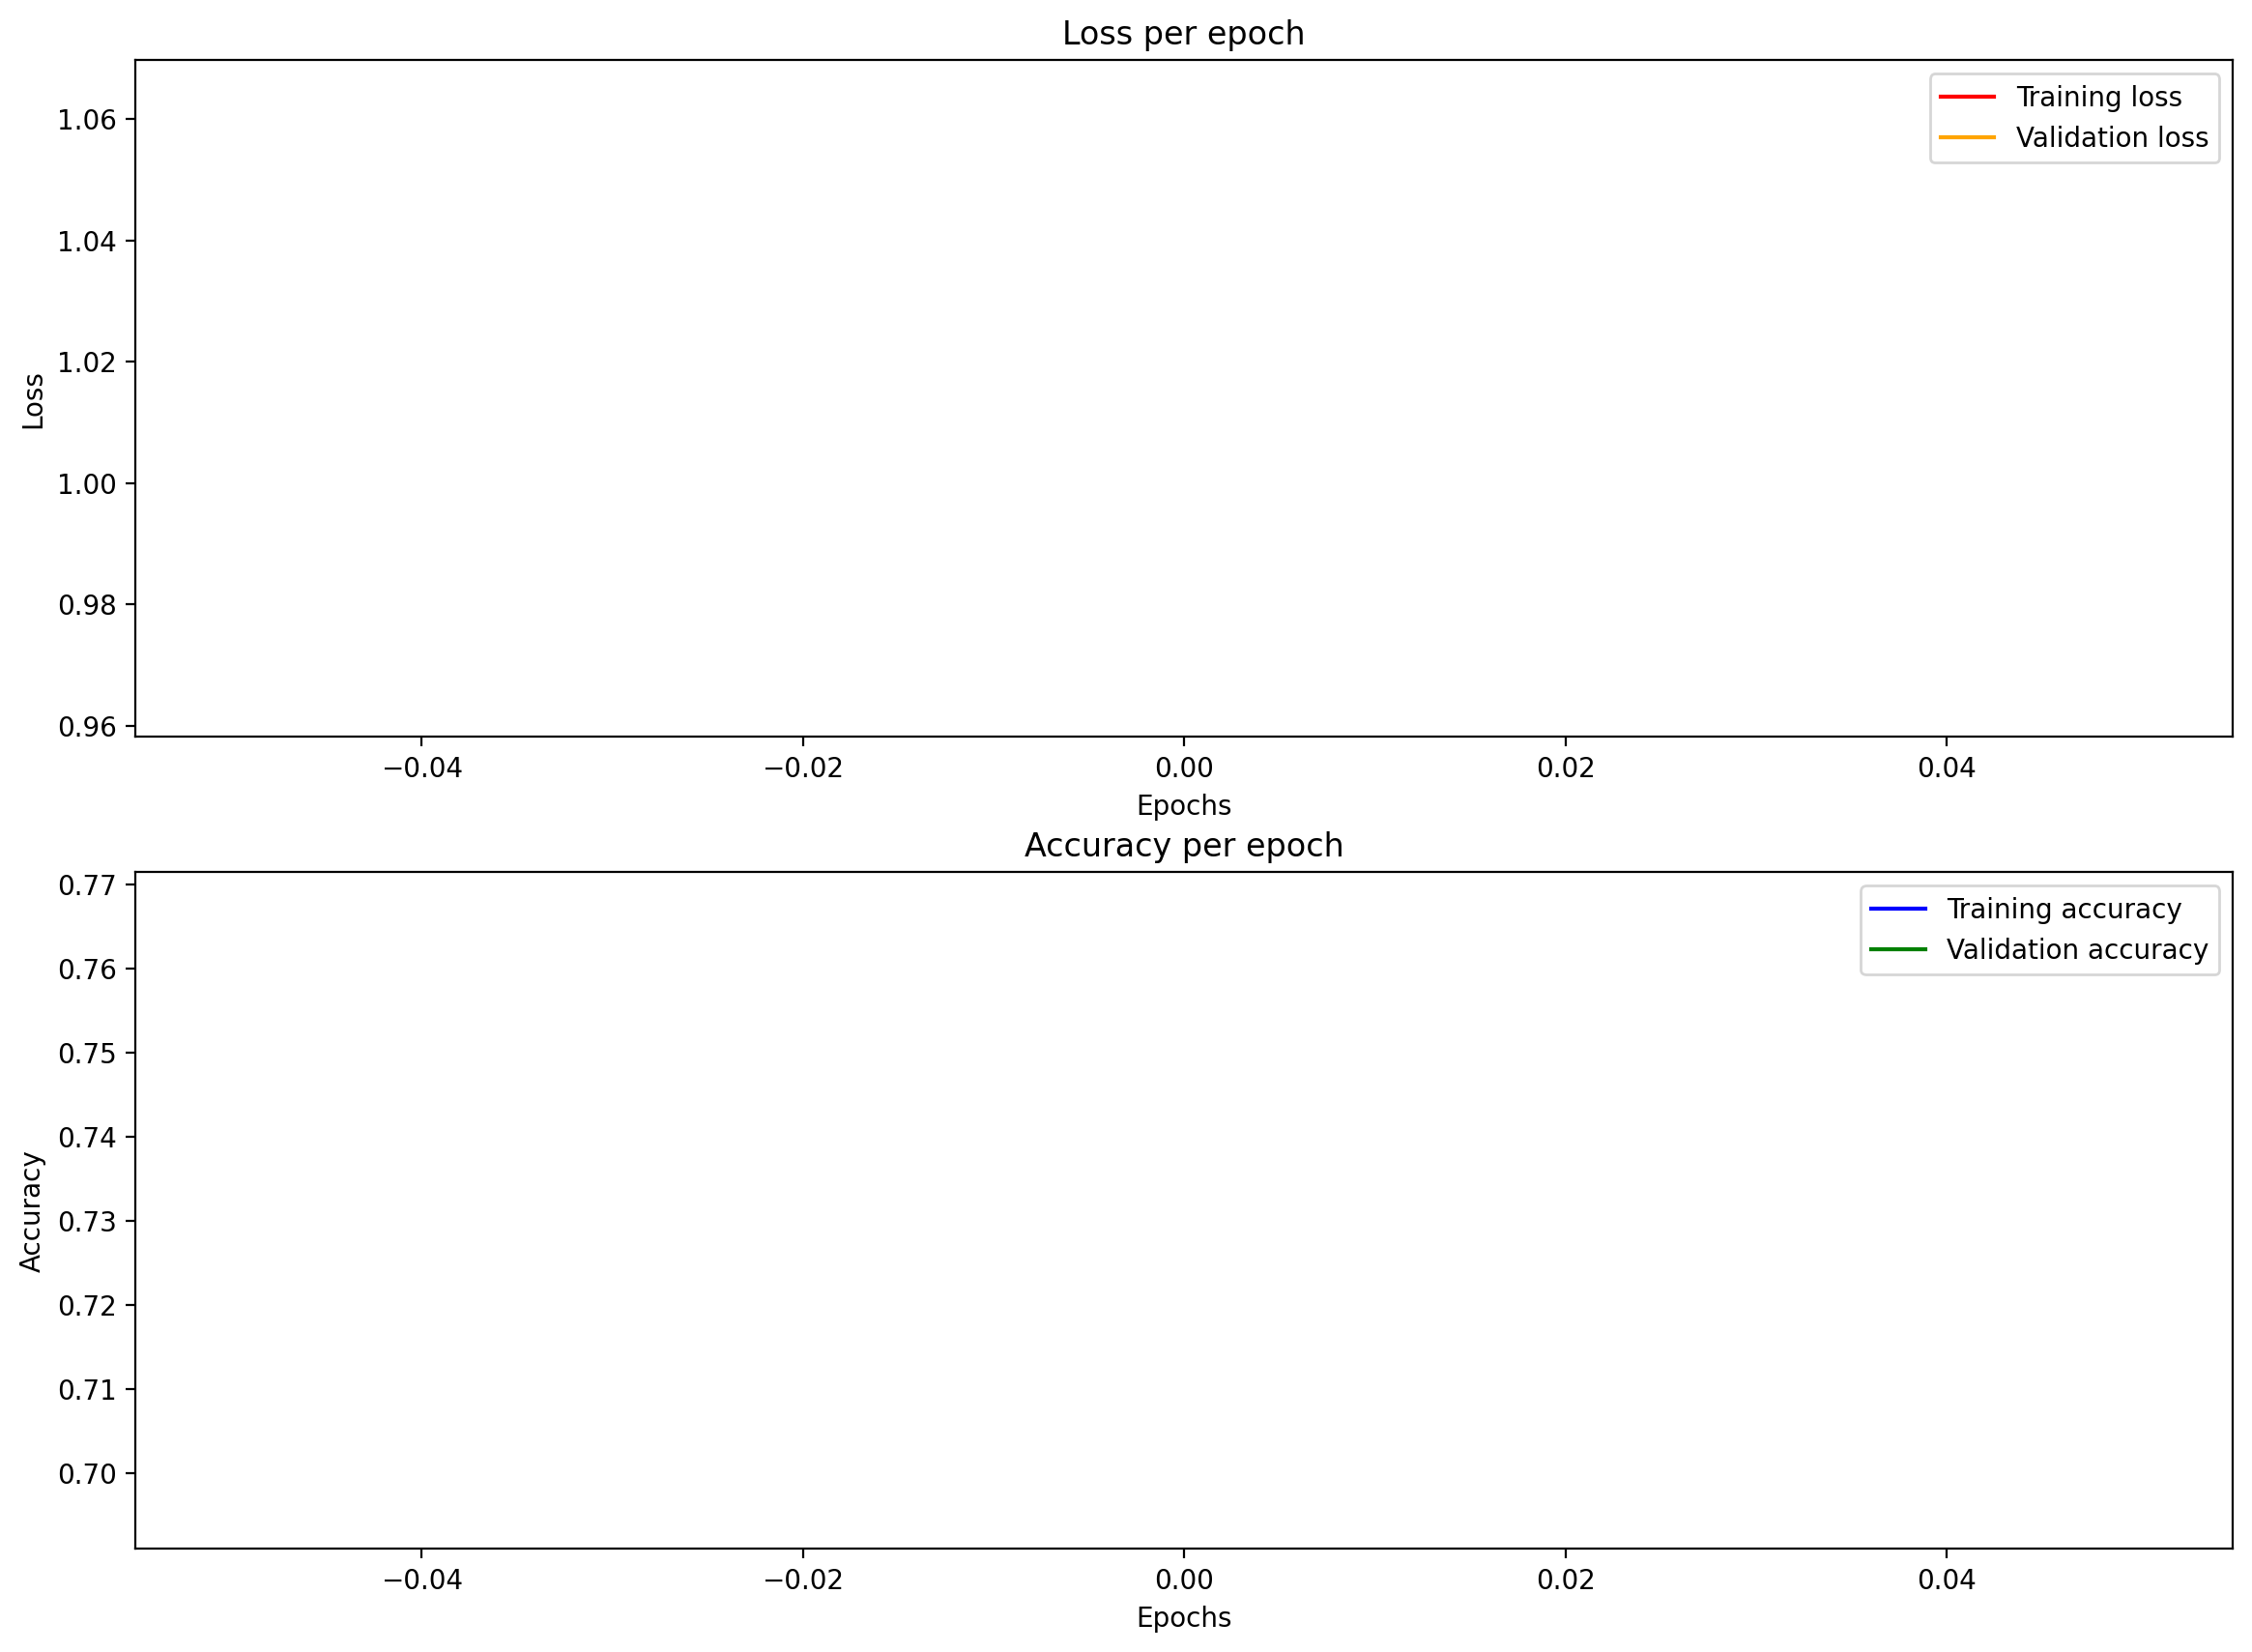

Running valid Loss: 0.7282 Running Accuracy: 0.8191: 100%|██████████| 13/13 [00:11<00:00,  1.16batch/s]


Final valid Loss: 0.7282 Final Accuracy: 0.8191
Epoch 2/50
----------


Running train Loss: 1.0331 Running Accuracy: 0.7245: 100%|██████████| 103/103 [00:59<00:00,  1.73batch/s]


Final train Loss: 1.0331 Final Accuracy: 0.7245


Running valid Loss: 0.7138 Running Accuracy: 0.8264: 100%|██████████| 13/13 [00:08<00:00,  1.59batch/s]


Final valid Loss: 0.7138 Final Accuracy: 0.8264
Epoch 3/50
----------


Running train Loss: 1.0196 Running Accuracy: 0.7285: 100%|██████████| 103/103 [01:00<00:00,  1.70batch/s]


Final train Loss: 1.0196 Final Accuracy: 0.7285


Running valid Loss: 0.7150 Running Accuracy: 0.8313: 100%|██████████| 13/13 [00:08<00:00,  1.60batch/s]


Final valid Loss: 0.7150 Final Accuracy: 0.8313
Epoch 4/50
----------


Running train Loss: 1.0149 Running Accuracy: 0.7285: 100%|██████████| 103/103 [01:00<00:00,  1.70batch/s]


Final train Loss: 1.0149 Final Accuracy: 0.7285


Running valid Loss: 0.7091 Running Accuracy: 0.8240: 100%|██████████| 13/13 [00:08<00:00,  1.59batch/s]


Final valid Loss: 0.7091 Final Accuracy: 0.8240
Epoch 5/50
----------


Running train Loss: 1.0408 Running Accuracy: 0.7183: 100%|██████████| 103/103 [01:00<00:00,  1.70batch/s]


Final train Loss: 1.0408 Final Accuracy: 0.7183


Running valid Loss: 0.7280 Running Accuracy: 0.8227: 100%|██████████| 13/13 [00:08<00:00,  1.58batch/s]


Final valid Loss: 0.7280 Final Accuracy: 0.8227
Epoch 6/50
----------


Running train Loss: 1.0239 Running Accuracy: 0.7279: 100%|██████████| 103/103 [01:04<00:00,  1.61batch/s]


Final train Loss: 1.0239 Final Accuracy: 0.7279


Running valid Loss: 0.7294 Running Accuracy: 0.8130: 100%|██████████| 13/13 [00:08<00:00,  1.58batch/s]


Final valid Loss: 0.7294 Final Accuracy: 0.8130
Epoch 7/50
----------


Running train Loss: 1.0247 Running Accuracy: 0.7263: 100%|██████████| 103/103 [01:00<00:00,  1.70batch/s]


Final train Loss: 1.0247 Final Accuracy: 0.7263


Running valid Loss: 0.7005 Running Accuracy: 0.8325: 100%|██████████| 13/13 [00:07<00:00,  1.71batch/s]


Final valid Loss: 0.7005 Final Accuracy: 0.8325
Epoch 8/50
----------


Running train Loss: 0.9899 Running Accuracy: 0.7317: 100%|██████████| 103/103 [00:54<00:00,  1.90batch/s]


Final train Loss: 0.9899 Final Accuracy: 0.7317


Running valid Loss: 0.6966 Running Accuracy: 0.8337: 100%|██████████| 13/13 [00:07<00:00,  1.83batch/s]


Final valid Loss: 0.6966 Final Accuracy: 0.8337
Epoch 9/50
----------


Running train Loss: 0.9989 Running Accuracy: 0.7314: 100%|██████████| 103/103 [00:54<00:00,  1.90batch/s]


Final train Loss: 0.9989 Final Accuracy: 0.7314


Running valid Loss: 0.7068 Running Accuracy: 0.8191: 100%|██████████| 13/13 [00:07<00:00,  1.83batch/s]


Final valid Loss: 0.7068 Final Accuracy: 0.8191
Epoch 10/50
----------


Running train Loss: 1.0136 Running Accuracy: 0.7302: 100%|██████████| 103/103 [00:53<00:00,  1.91batch/s]


Final train Loss: 1.0136 Final Accuracy: 0.7302


Running valid Loss: 0.7498 Running Accuracy: 0.8081: 100%|██████████| 13/13 [00:07<00:00,  1.84batch/s]


Final valid Loss: 0.7498 Final Accuracy: 0.8081
Epoch 11/50
----------


Running train Loss: 1.0287 Running Accuracy: 0.7227: 100%|██████████| 103/103 [00:53<00:00,  1.91batch/s]


Final train Loss: 1.0287 Final Accuracy: 0.7227


Running valid Loss: 0.7182 Running Accuracy: 0.8191: 100%|██████████| 13/13 [00:07<00:00,  1.82batch/s]


Final valid Loss: 0.7182 Final Accuracy: 0.8191
Epoch 12/50
----------


Running train Loss: 1.0251 Running Accuracy: 0.7299: 100%|██████████| 103/103 [00:53<00:00,  1.92batch/s]


Final train Loss: 1.0251 Final Accuracy: 0.7299


Running valid Loss: 0.6952 Running Accuracy: 0.8496: 100%|██████████| 13/13 [00:07<00:00,  1.85batch/s]


Final valid Loss: 0.6952 Final Accuracy: 0.8496
Epoch 13/50
----------


Running train Loss: 1.0008 Running Accuracy: 0.7300: 100%|██████████| 103/103 [00:53<00:00,  1.92batch/s]


Final train Loss: 1.0008 Final Accuracy: 0.7300


Running valid Loss: 0.6985 Running Accuracy: 0.8350: 100%|██████████| 13/13 [00:07<00:00,  1.83batch/s]


Final valid Loss: 0.6985 Final Accuracy: 0.8350
Epoch 14/50
----------


Running train Loss: 1.0160 Running Accuracy: 0.7343: 100%|██████████| 103/103 [00:53<00:00,  1.92batch/s]


Final train Loss: 1.0160 Final Accuracy: 0.7343


Running valid Loss: 0.6933 Running Accuracy: 0.8289: 100%|██████████| 13/13 [00:07<00:00,  1.85batch/s]


Final valid Loss: 0.6933 Final Accuracy: 0.8289
Epoch 15/50
----------


Running train Loss: 0.9945 Running Accuracy: 0.7381: 100%|██████████| 103/103 [00:53<00:00,  1.92batch/s]


Final train Loss: 0.9945 Final Accuracy: 0.7381


Running valid Loss: 0.6914 Running Accuracy: 0.8264: 100%|██████████| 13/13 [00:06<00:00,  1.87batch/s]


Final valid Loss: 0.6914 Final Accuracy: 0.8264
Epoch 16/50
----------


Running train Loss: 0.9609 Running Accuracy: 0.7382: 100%|██████████| 103/103 [00:53<00:00,  1.92batch/s]


Final train Loss: 0.9609 Final Accuracy: 0.7382


Running valid Loss: 0.7387 Running Accuracy: 0.8142: 100%|██████████| 13/13 [00:07<00:00,  1.82batch/s]


Final valid Loss: 0.7387 Final Accuracy: 0.8142
Epoch 17/50
----------


Running train Loss: 1.0187 Running Accuracy: 0.7378: 100%|██████████| 103/103 [00:53<00:00,  1.91batch/s]


Final train Loss: 1.0187 Final Accuracy: 0.7378


Running valid Loss: 0.7249 Running Accuracy: 0.8227: 100%|██████████| 13/13 [00:07<00:00,  1.81batch/s]


Final valid Loss: 0.7249 Final Accuracy: 0.8227
Epoch 18/50
----------


Running train Loss: 0.9976 Running Accuracy: 0.7363: 100%|██████████| 103/103 [00:53<00:00,  1.93batch/s]


Final train Loss: 0.9976 Final Accuracy: 0.7363


Running valid Loss: 0.6976 Running Accuracy: 0.8227: 100%|██████████| 13/13 [00:06<00:00,  1.87batch/s]


Final valid Loss: 0.6976 Final Accuracy: 0.8227
Epoch 19/50
----------


Running train Loss: 0.9678 Running Accuracy: 0.7415: 100%|██████████| 103/103 [00:53<00:00,  1.92batch/s]


Final train Loss: 0.9678 Final Accuracy: 0.7415


Running valid Loss: 0.6700 Running Accuracy: 0.8325: 100%|██████████| 13/13 [00:06<00:00,  1.86batch/s]


Final valid Loss: 0.6700 Final Accuracy: 0.8325
Epoch 20/50
----------


Running train Loss: 0.9914 Running Accuracy: 0.7398: 100%|██████████| 103/103 [00:55<00:00,  1.85batch/s]


Final train Loss: 0.9914 Final Accuracy: 0.7398


Running valid Loss: 0.6862 Running Accuracy: 0.8337: 100%|██████████| 13/13 [00:07<00:00,  1.69batch/s]


Final valid Loss: 0.6862 Final Accuracy: 0.8337
Epoch 21/50
----------


Running train Loss: 0.9933 Running Accuracy: 0.7285: 100%|██████████| 103/103 [01:09<00:00,  1.48batch/s]


Final train Loss: 0.9933 Final Accuracy: 0.7285


Running valid Loss: 0.6864 Running Accuracy: 0.8166: 100%|██████████| 13/13 [00:11<00:00,  1.17batch/s]


Final valid Loss: 0.6864 Final Accuracy: 0.8166
Epoch 22/50
----------


Running train Loss: 0.9522 Running Accuracy: 0.7448: 100%|██████████| 103/103 [01:05<00:00,  1.57batch/s]


Final train Loss: 0.9522 Final Accuracy: 0.7448


Running valid Loss: 0.7016 Running Accuracy: 0.8313: 100%|██████████| 13/13 [00:08<00:00,  1.61batch/s]


Final valid Loss: 0.7016 Final Accuracy: 0.8313
Epoch 23/50
----------


Running train Loss: 0.9963 Running Accuracy: 0.7358: 100%|██████████| 103/103 [00:58<00:00,  1.76batch/s]


Final train Loss: 0.9963 Final Accuracy: 0.7358


Running valid Loss: 0.7038 Running Accuracy: 0.8154: 100%|██████████| 13/13 [00:07<00:00,  1.65batch/s]


Final valid Loss: 0.7038 Final Accuracy: 0.8154
Epoch 24/50
----------


Running train Loss: 0.9503 Running Accuracy: 0.7421: 100%|██████████| 103/103 [00:55<00:00,  1.86batch/s]


Final train Loss: 0.9503 Final Accuracy: 0.7421


Running valid Loss: 0.6987 Running Accuracy: 0.8117: 100%|██████████| 13/13 [00:07<00:00,  1.80batch/s]


Final valid Loss: 0.6987 Final Accuracy: 0.8117
Epoch 25/50
----------


Running train Loss: 0.9426 Running Accuracy: 0.7444:  65%|██████▌   | 67/103 [00:40<00:21,  1.67batch/s]


KeyboardInterrupt: 

In [287]:
%timeit train(model=peft_model , epochs=epochs, learning_rate=learning_rate,scheduler=scheduler, criterion=criterion, optimizer=optimizer, training_loader=dataloaders['training'],validation_loader= dataloaders['validation'],device=device)

### **Quantizing EfficientNet model**

In [402]:


model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
qmodel=model.to(device)
qmodel.qconfig=torch.quantization.default_qat_qconfig
qmodel== torch.quantization.prepare_qat(qmodel, inplace=True)



### ***Quantized Model Summary before LoRA***

In [398]:

torchinfo.summary(qmodel, input_size=( 1,3, 224, 224), col_names=("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose=0)

Layer (type:depth-idx)                                                 Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
EfficientNet                                                           [1, 3, 224, 224]          [1, 102]                  --                        --                        --
├─Conv2dSame: 1-1                                                      [1, 3, 224, 224]          [1, 24, 112, 112]         (648)                     [3, 3]                    8,128,512
├─BatchNormAct2d: 1-2                                                  [1, 24, 112, 112]         [1, 24, 112, 112]         48                        --                        --
│    └─Identity: 2-1                                                   [1, 24, 112, 112]         [1, 24, 112, 112]         --                        --                        --
│    └─SiLU: 2-2                                                       [1, 24, 112, 112]        

In [403]:
qpeft_model = peft.get_peft_model(qmodel, config).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(qpeft_model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max = 32, eta_min = 1e-4)
peft_model.print_trainable_parameters()
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 50
learning_rate = 0.01

trainable params: 23,344 || all params: 20,714,214 || trainable%: 0.11269556257360284


### ***Quantized Model Summary after LoRA***

In [404]:

torchinfo.summary(qpeft_model, input_size=(1, 3, 224, 224), col_names=("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose=0)

Layer (type:depth-idx)                                                           Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
PeftModel                                                                        [1, 3, 224, 224]          [1, 102]                  --                        --                        --
├─LoraModel: 1-1                                                                 --                        --                        --                        --                        --
│    └─EfficientNet: 2-1                                                         [1, 3, 224, 224]          [1, 102]                  --                        --                        --
│    │    └─Conv2dSame: 3-1                                                      [1, 3, 224, 224]          [1, 24, 112, 112]         (648)                     [3, 3]                    8,128,512
│    │    └─BatchNormAct2d: 3-2               

### Training QLoRA EfficientNet model

Epoch 1/50
----------


Running train Loss: 3.2248 Running Accuracy: 0.2358: 100%|██████████| 103/103 [02:03<00:00,  1.20s/batch]


Final train Loss: 3.2248 Final Accuracy: 0.2358


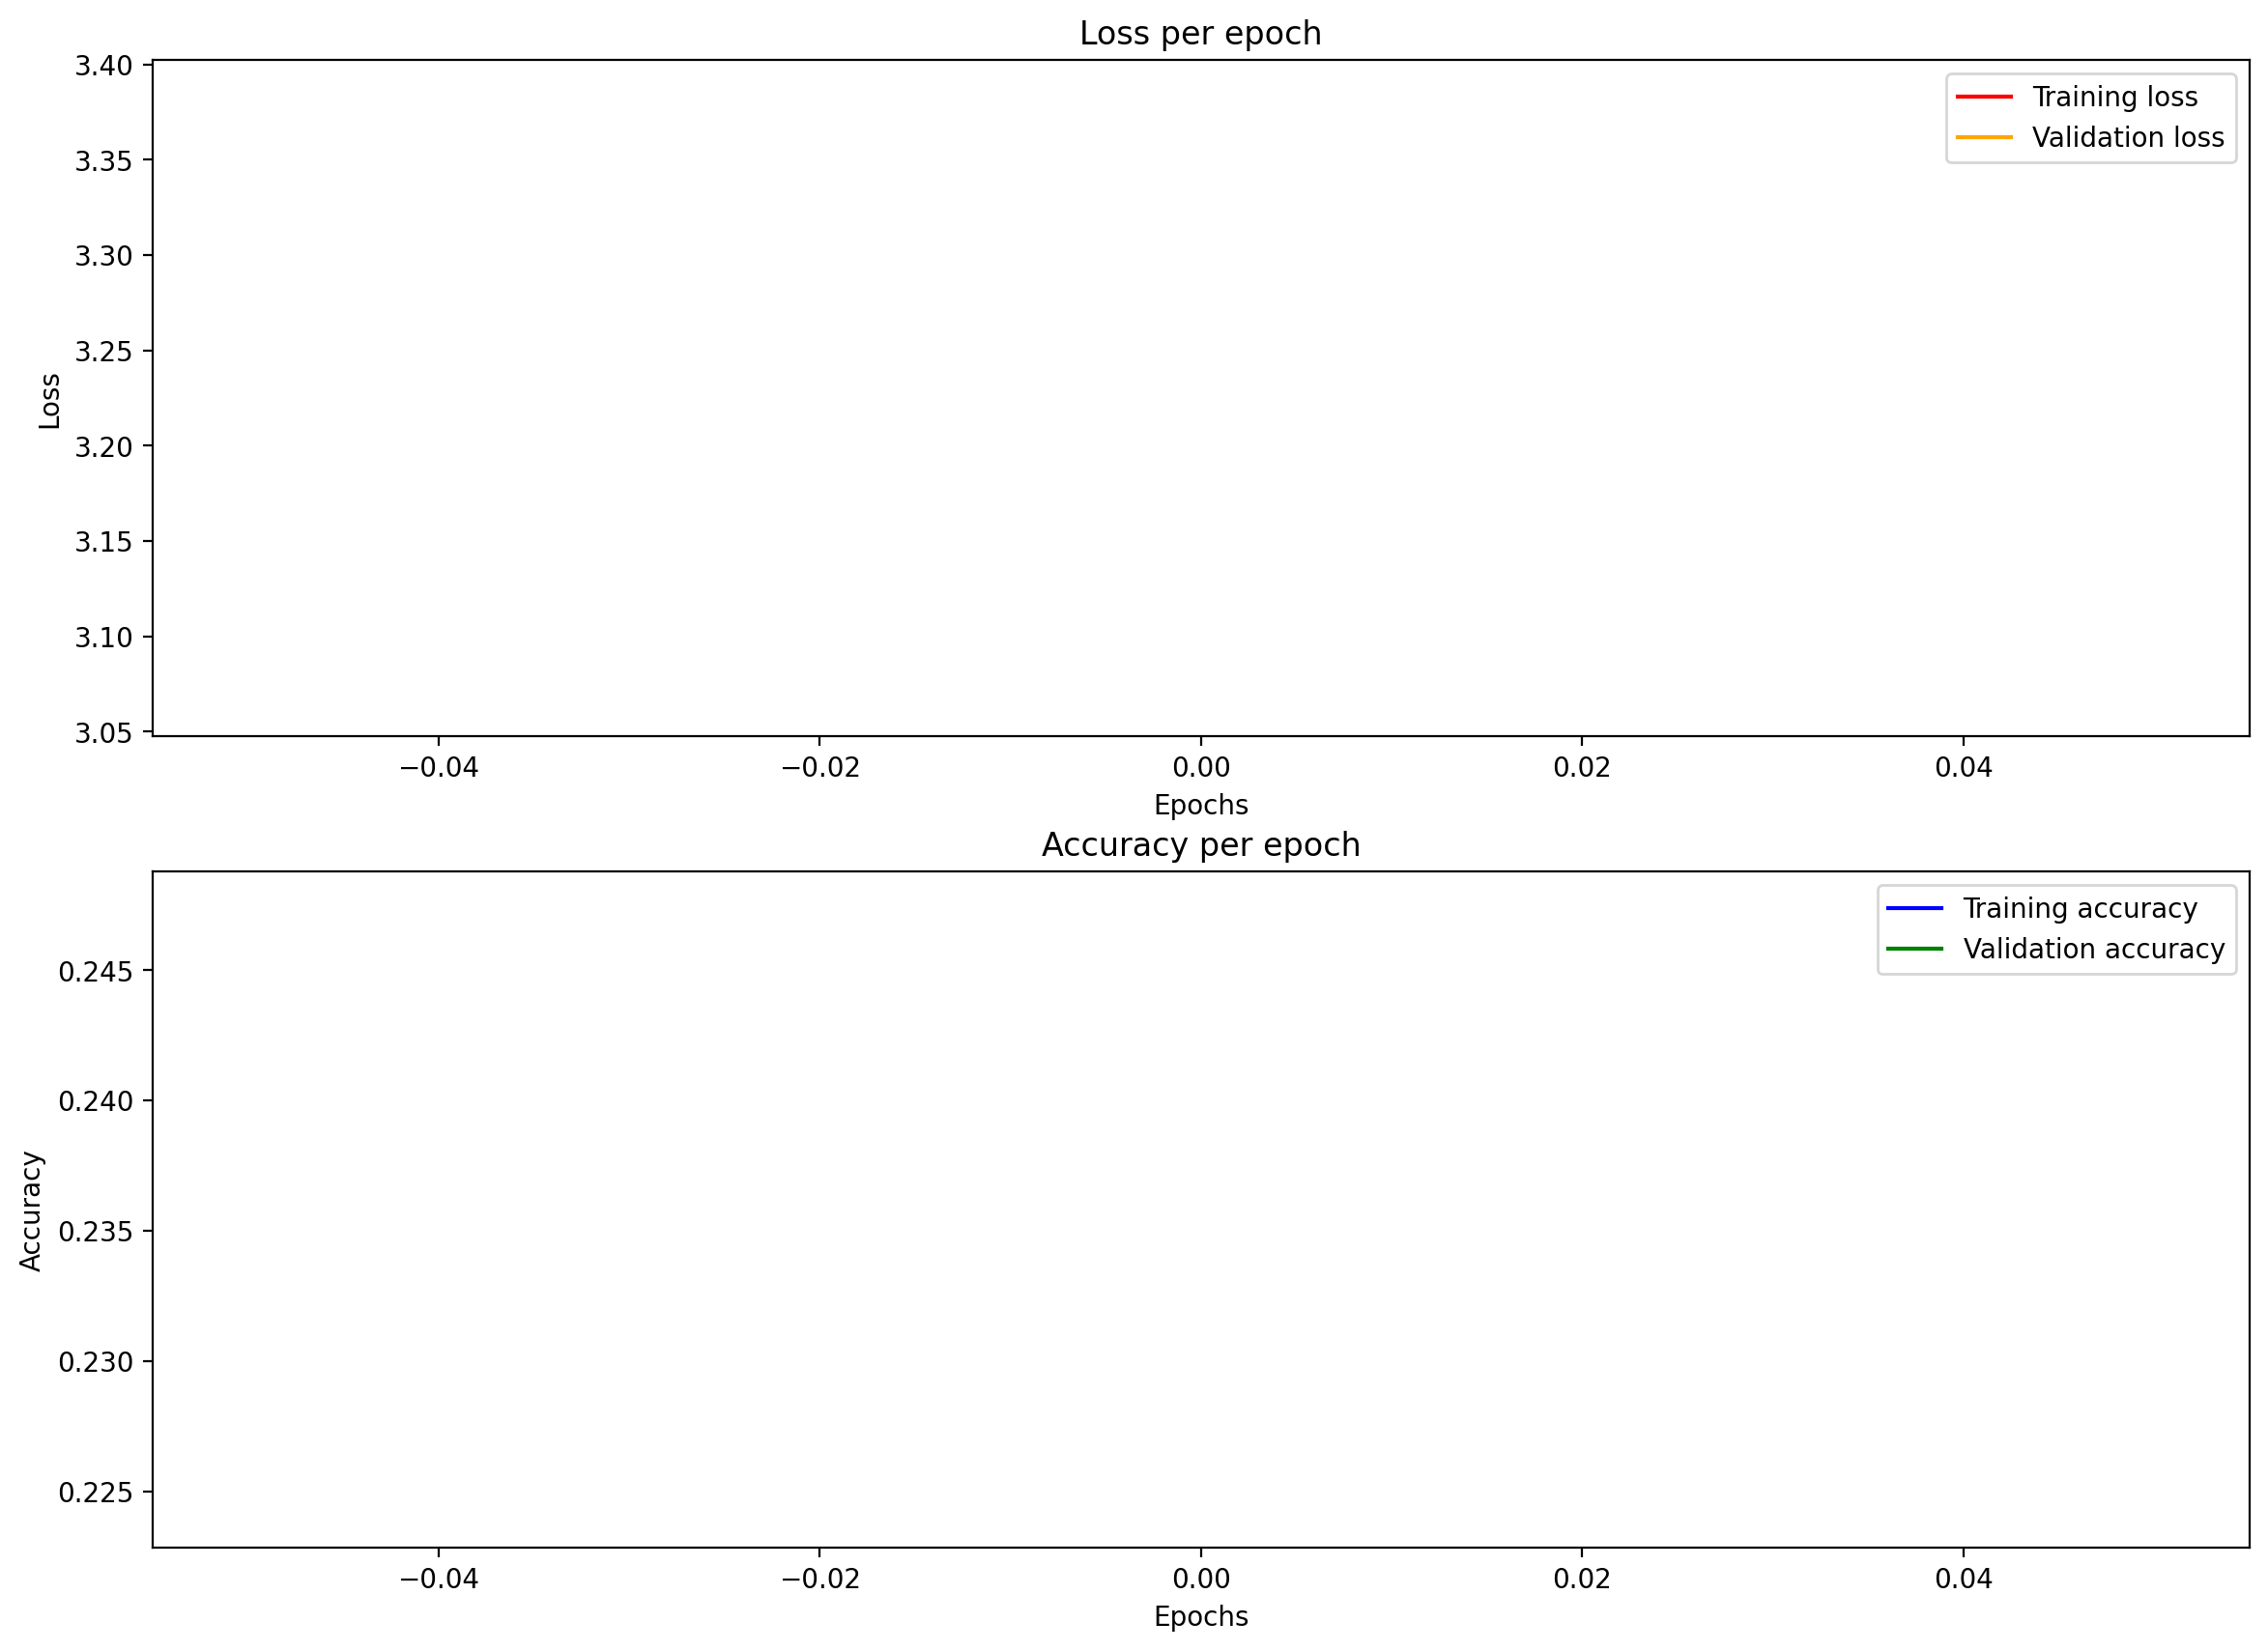

Running valid Loss: 2.0664 Running Accuracy: 0.4756: 100%|██████████| 13/13 [00:15<00:00,  1.18s/batch]


Final valid Loss: 2.0664 Final Accuracy: 0.4756
Epoch 2/50
----------


Running train Loss: 2.1909 Running Accuracy: 0.4216:  53%|█████▎    | 55/103 [01:06<00:58,  1.21s/batch]


KeyboardInterrupt: 

In [405]:
%timeit train(model=qpeft_model , epochs=epochs, learning_rate=learning_rate,scheduler=scheduler, criterion=criterion, optimizer=optimizer, training_loader=dataloaders['training'],validation_loader= dataloaders['validation'],device=device)

In [ ]:

model_quantized_and_trained = convert(qpeft_model, inplace=False)

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [77]:
# TODO: Save the checkpoint 
checkpoint_path = 'tf_efficientnetv2_s_LoRA.pth'
state= {
    'arch': 'tf_efficientnetv2_s',
    'learning_rate': learning_rate,
    'hidden_units': hidden_layers,
    'epochs': epochs,
    'state_dict': peft_model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'class_to_idx': peft_model.class_to_idx
}

torch.save(state, checkpoint_path)

In [ ]:
# TODO: Save the checkpoint 
checkpoint_path = 'tf_efficientnetv2_s_quantized_LoRA.pth'
state= {
    'arch': 'tf_efficientnetv2_s',
    'learning_rate': learning_rate,
    'hidden_units': hidden_layers,
    'epochs': epochs,
    'state_dict': model_quantized_and_trained.state_dict(),
    'optimizer': optimizer.state_dict(),
    'class_to_idx': model_quantized_and_trained.class_to_idx
}

torch.save(state, checkpoint_path)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [80]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
checkpoint_path = 'tf_efficientnetv2_s_LoRA'
state = torch.load(checkpoint_path)
learning_rate = state['learning_rate']
class_to_idx = state['class_to_idx']
hidden_units = state['hidden_units']
arch = state['arch']
model = build_model(hidden_units, class_to_idx,'cuda')
model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])

print("loaded model : {}, with arch : {}, learning_rate: {}, hidden_layers: {}, epochs: {}".format( checkpoint_path, arch, learning_rate, hidden_layers, epochs))

Loaded pretrained weights for efficientnet-b0
 classifier_input_size:  1280
loaded model : efficientnet-b0.pth, with arch : efficientnet-b0, learning_rate: 0.001, hidden_layers: 512, epochs: 30


In [ ]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
checkpoint_path = 'tf_efficientnetv2_s_quantized_LoRA'
state = torch.load(checkpoint_path)
learning_rate = state['learning_rate']
class_to_idx = state['class_to_idx']
hidden_units = state['hidden_units']
arch = state['arch']
model = build_model(hidden_units, class_to_idx,'cuda')
model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])

print("loaded model : {}, with arch : {}, learning_rate: {}, hidden_layers: {}, epochs: {}".format( checkpoint_path, arch, learning_rate, hidden_layers, epochs))

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [81]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    size= 224
    # TODO: Process a PIL image for use in a PyTorch model
    width, height = image.size
    
    if height > width:
        height = int(max(height * size / width, 1))
        width = int(size)
    else:
        width = int(max(width * size / height, 1))
        height = int(size)
    resized_image = image.resize((width, height))
    x0 = (width - size) / 2
    y0 = (height - size) / 2
    x1 = x0 + size
    y1 = y0 + size
    cropped_image = image.crop((x0, y0, x1, y1))
    np_image = np.array(cropped_image) / 255.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image_array = (np_image - mean) / std
    np_image_array = np_image.transpose((2, 0, 1))
    
    return np_image_array

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [82]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [83]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.eval()
    use_gpu = False
    if torch.cuda.is_available():
        use_gpu = True
        model = model.cuda()
    else:
        model = model.cpu()
    image = Image.open(image_path)
    np_array = process_image(image)
    tensor = torch.from_numpy(np_array)
    if use_gpu:
        var_inputs = tensor.float().cuda()
    else:       
        var_inputs = tensor
    var_inputs = var_inputs.unsqueeze(0)
    with torch.no_grad():
        output = model.forward(var_inputs)
    ps = torch.exp(output).data.topk(topk)
    probabilities = ps[0].cpu() if use_gpu else ps[0]
    classes = ps[1].cpu() if use_gpu else ps[1]
    class_to_idx_inverted = {model.class_to_idx[k]: k for k in model.class_to_idx}
    mapped_classes = list()
    for label in classes.numpy()[0]:
        mapped_classes.append(class_to_idx_inverted[label])
    
    return probabilities.numpy()[0], mapped_classes


In [84]:
image_path = test_dir +'/12/image_04012.jpg'
probabilities, classes = predict(image_path, model)
print('Probabilities: ', probabilities)
print('Classes: ', classes)

Probabilities:  [0.09563961 0.08632266 0.0724994  0.07211457 0.06593767]
Classes:  ['1', '14', '49', '2', '86']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

frangipani
rose
moon orchid
giant white arum lily
thorn apple


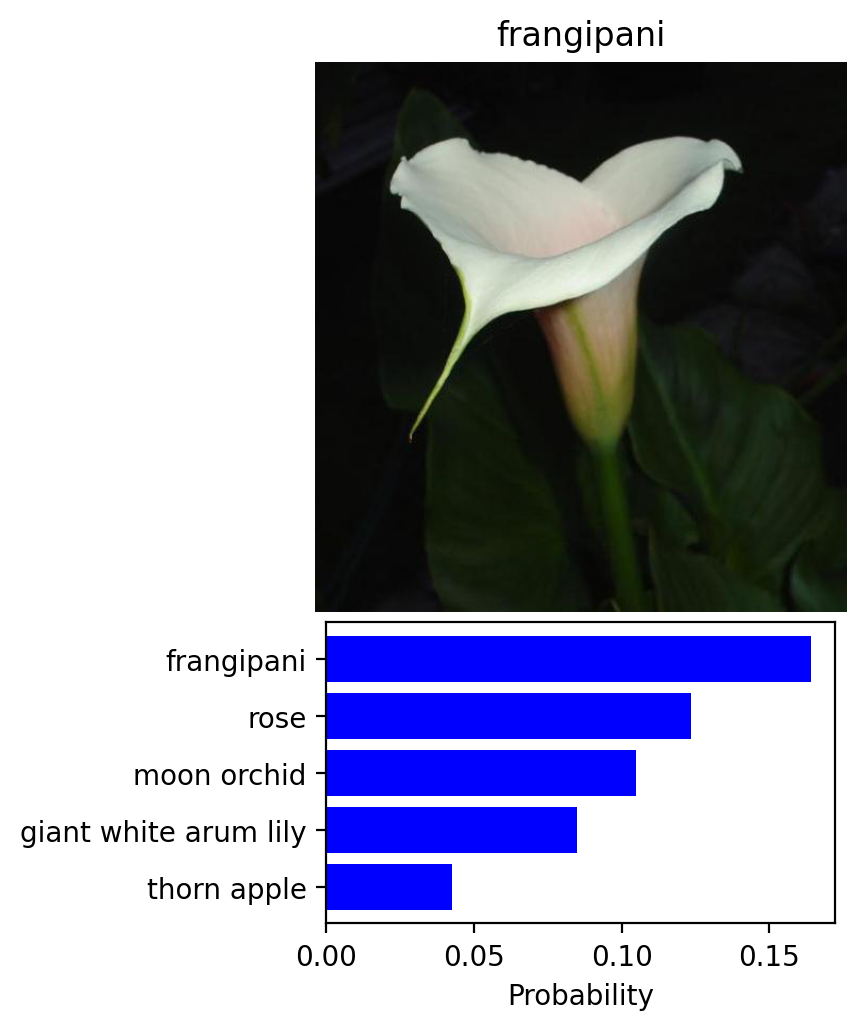

In [85]:
# TODO: Display an image along with the top 5 classes
image_path = test_dir +'/20/image_04912.jpg'
probabilities, classes = predict(image_path, model)
max_index = np.argmax(probabilities)
max_probability = probabilities[max_index]
label = classes[max_index]

fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
ax2 = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)

image = Image.open(image_path)
ax1.axis('off')
ax1.set_title(cat_to_name[label])
ax1.imshow(image)

labels
for c1 in classes:
    print(cat_to_name[c1])

y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([cat_to_name[x] for x in classes])
ax2.invert_yaxis()  # probabilities read top-to-bottom
ax2.set_xlabel('Probability')
ax2.barh(y_pos, probabilities, xerr=0, align='center', color='blue')

plt.show()

## Reminder for Workspace users
If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.

In [2]:


# Create the temporary directory if it doesn't exist
temp_directory = '~/opt'
os.makedirs(temp_directory, exist_ok=True)
directory = '/workspace/home/aipnd-project'
# Iterate over the files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.pth'):
        # Remove the .pth files or move them to the temporary directory
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path):
            # Remove the file
            os.remove(file_path)
        else:
            # Move the file to the temporary directory
            shutil.move(file_path, temp_directory)
